In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sympy.printing.pretty.pretty_symbology import line_width

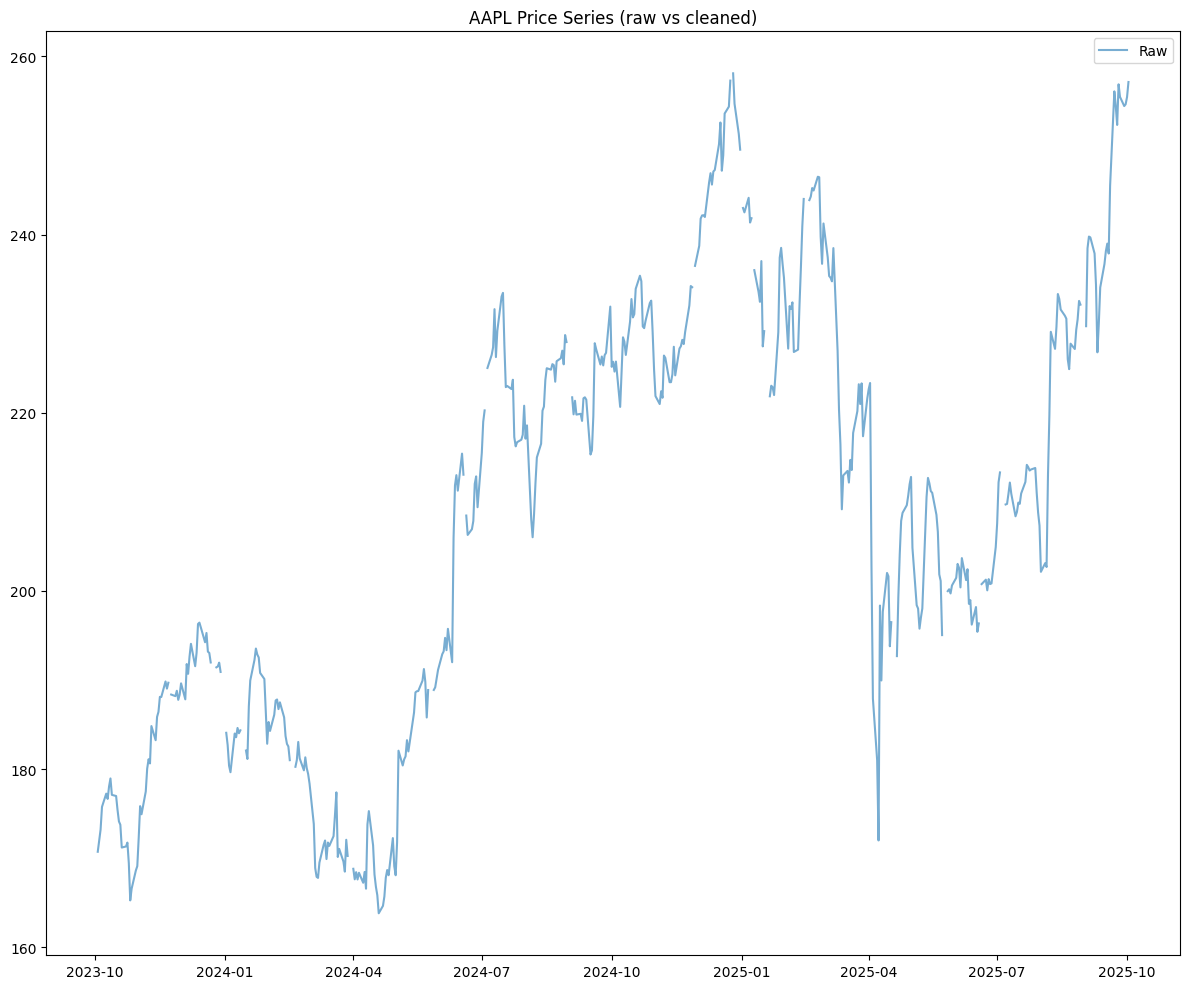

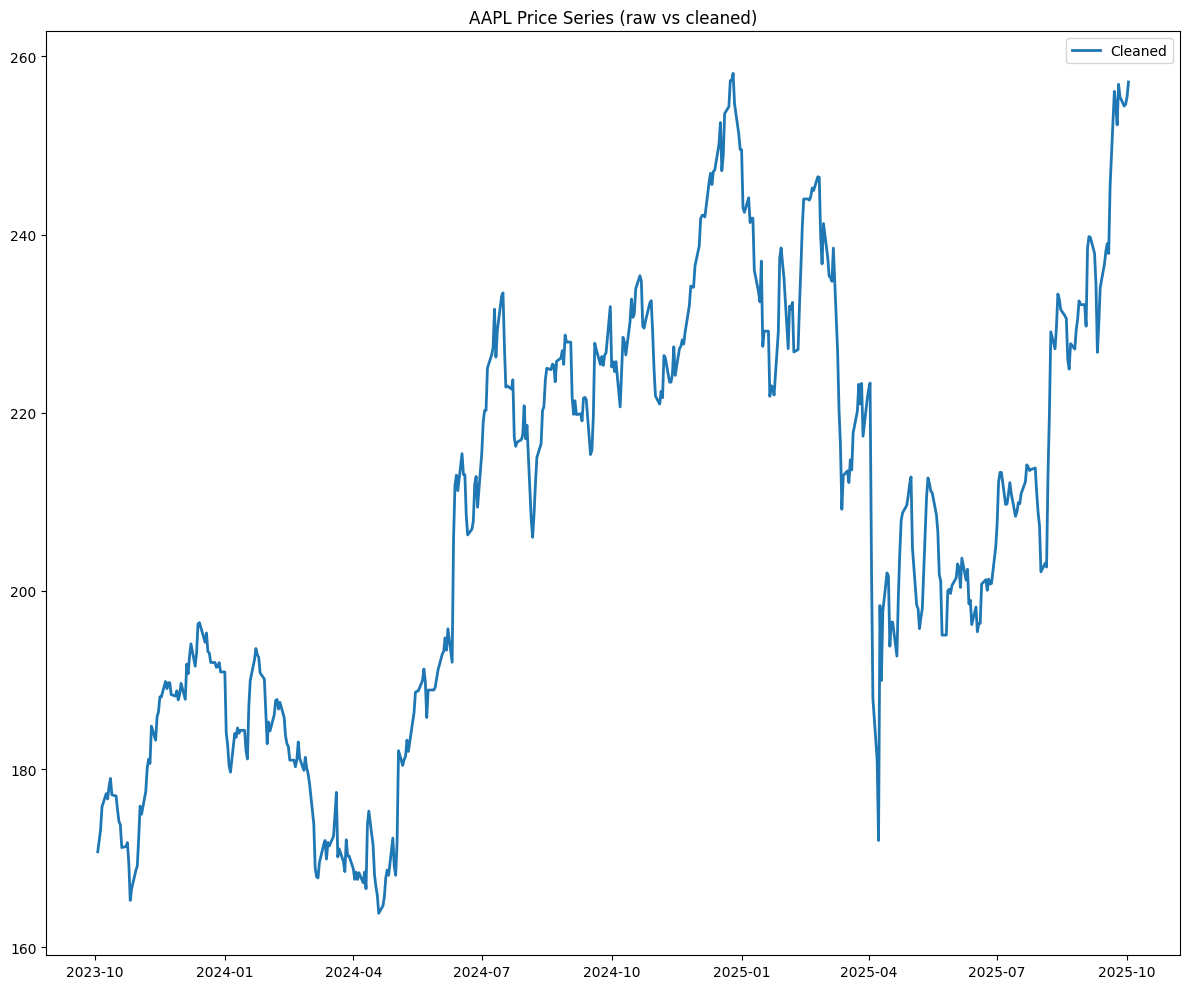

                   raw      filled       clean
2023-10-03  170.727707  170.727707  170.727707
2023-10-04  171.975510  171.975510  171.975510
2023-10-05  173.213409  173.213409  173.213409
2023-10-06  175.768372  175.768372  175.768372
2023-10-09  177.253830  177.253830  177.253830
Total outliers flagged:0


In [19]:
def clean_time_series(ticker, period="2y",interval="1d",sigma_thresh=5):
    df=yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df.empty:
        raise SystemExit("No data returned.")

    if "Adj Close" in df.columns:
        s = df["Adj Close"].copy()
    elif "Close" in df.columns:
        s = df["Close"].copy()
    else:
        raise SystemExit("No Close/Adj Close found.")

# Ensure Series, not DataFrame
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]

    s.name = "price"

    s=s[~s.index.duplicated(keep="last")]

    full_range=pd.date_range(start=s.index.min(), end=s.index.max(),freq="B")
    s=s.reindex(full_range)

    s_filled=s.ffill()


    rolling_mean=s_filled.rolling(20,min_periods=5).mean()
    rolling_std=s_filled.rolling(20,min_periods=5).std()
    zscore=(s_filled-rolling_mean) / rolling_std
    outliers=zscore.abs()>sigma_thresh


    s_clean=s_filled.copy()
    s_clean[outliers]=np.nan
    s_clean=s_clean.ffill()


    out_df=pd.DataFrame({"raw":s,"filled":s_filled,"clean":s_clean})
    out_df.to_csv(f"{ticker}_cleaned_timeseries.csv")


    plt.figure(figsize=(12,10))
    plt.plot(out_df.index,out_df["raw"],label="Raw",alpha=0.6)
    plt.title(f"{ticker} Price Series (raw vs cleaned)")
    plt.legend(); plt.tight_layout(); plt.show()


    plt.figure(figsize=(12,10))
    plt.plot(out_df.index,out_df["clean"],label="Cleaned",linewidth=2)
    plt.title(f"{ticker} Price Series (raw vs cleaned)")
    plt.legend(); plt.tight_layout(); plt.show()

    return out_df, outliers

if __name__=="__main__":
    cleaned,outliers=clean_time_series("AAPL")
    print(cleaned.head())
    print(f"Total outliers flagged:{outliers.sum()}")




